In [2]:
from fase.fileio import Table
import eagleSqlTools as egl
import numpy as np
import  matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})
import time
import pandas as pd

In [3]:
time.time()

1543327545.515232

In [10]:
# CONNECTION TO THE VIRGO DATABASE
con = egl.connect(user="giorgio",password='BN401kmd') 

In [12]:
QJ = 'SELECT '
QJ += '   des.mag_V_ext as d_mag_V_ext, '
QJ += '   des.SDSS_u_ext as d_SDSS_u_ext, '
QJ += '   prog.mag_V_ext as p_mag_V_ext, '
QJ += '   prog.SDSS_u_ext as p_SDSS_u_ext, ' 
QJ += '   prog.stellarmass as p_stellarmass, '
QJ += '   des.stellarmass as d_stellarmass '
QJ += 'FROM '
QJ += '   Gonzalez2014a..mr7 as des with(index(pk_mr7_galaxyid)), '
QJ += '   Gonzalez2014a..mr7 as prog with(forceseek,index(pk_mr7_galaxyid)) '
QJ += 'WHERE '
QJ += '   des.snapnum = 47 AND '
QJ += '   prog.galaxyid BETWEEN des.galaxyid AND des.mainleafid '
QJ += '   AND prog.snapnum = 37 '
QJ += '   AND des.stellarmass>0.1 '

In [6]:
QUERY = 'select des.mag_V_ext as d_mag_V_ext, des.SDSS_u_ext as d_SDSS_u_ext, prog.mag_V_ext as p_mag_V_ext, prog.SDSS_u_ext as p_SDSS_u_ext ,prog.stellarmass as p_stellarmass,des.stellarmass as d_stellarmass '#,prog.redshift as p_redshift, des.mdhalo as d_mdhalo, prog.mdhalo as p_mdhalo ' 
#QUERY = 'select count(*) as c '
QUERY += 'from  Gonzalez2014a..mr7 as prog with(forceseek), Gonzalez2014a..mr7 as des '
QUERY += 'where  des.snapnum = 47 and ' #redshift=0.456577 
QUERY += 'prog.galaxyid between des.galaxyid and des.mainleafid '
QUERY += 'and prog.snapnum = 37 ' #redshift=1.173417
QUERY += 'and des.stellarmass>0.1'

# Timing the query

In [13]:
t1 = time.time()
JOHN_37_47 = egl.execute_query(con,QJ)
t2 = time.time()
print t2-t1 #1824.93539 (no forceseek)
#prog_37_47 = egl.execute_query(con,QUERY)

1441.91092014


In [19]:
#len(Prog_37_47)
#len(prog_37_47) #1591 #1271

len(JOHN_37_47)

3857651

In [44]:
#Save file in a txt file (do it just once)

#head = 'd_mag_V_ext d_SDSS_u_ext p_mag_V_ext p_SDSS_u_ext p_stellarmass d_stellarmass '
#np.savetxt('../data/JOHN_HELLY_prog_des_37_47.txt',JOHN_37_47,header=head,encoding='utf-8')

In [17]:
QJC = 'SELECT count(*) as c '
QJC += 'FROM '
QJC += '   Gonzalez2014a..mr7 as des with(index(pk_mr7_galaxyid)), '
QJC += '   Gonzalez2014a..mr7 as prog with(forceseek,index(pk_mr7_galaxyid)) '
QJC += 'WHERE '
QJC += '   des.snapnum = 47 AND '
QJC += '   prog.galaxyid BETWEEN des.galaxyid AND des.mainleafid '
QJC += '   AND prog.snapnum = 37 '
QJC += '   AND des.stellarmass>0.1 '

In [ ]:
JOHN_37_47_counts = egl.execute_query(con,QJC)

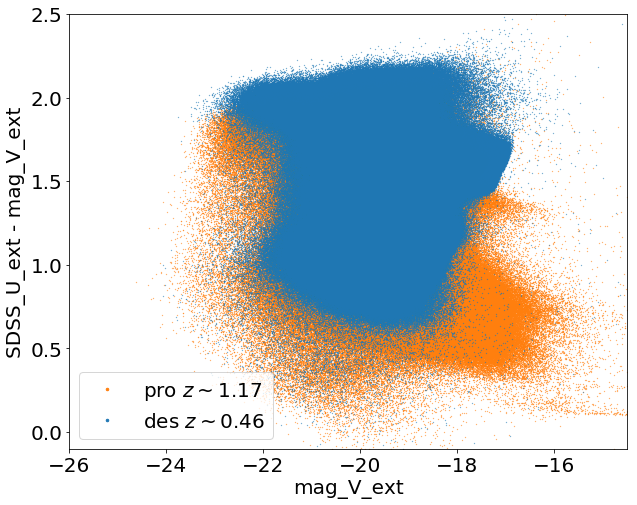

In [23]:
ALL = JOHN_37_47
plt.figure(figsize=(10,8))

plt.plot(ALL['p_mag_V_ext'],ALL['p_SDSS_u_ext']-ALL['p_mag_V_ext'],".",markersize=0.5,label=r'pro $z\sim1.17$',c='C1')
plt.plot(ALL['d_mag_V_ext'],ALL['d_SDSS_u_ext']-ALL['d_mag_V_ext'],".",markersize=0.5,label=r'des $z\sim0.46$',c='C0')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=10)

plt.xlim(-26,-14.5)
plt.ylim(-0.1,2.5)

plt.savefig("../plots/008/col_mag_des_prog.png")
plt.show()

In [24]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

In [37]:
V_des = ALL['d_mag_V_ext']
UV_des = ALL['d_SDSS_u_ext']-ALL['d_mag_V_ext']
V_pro = ALL['p_mag_V_ext']
UV_pro = ALL['p_SDSS_u_ext']-ALL['p_mag_V_ext']

xedge_des,yedge_des = EDGE(V_des,UV_des,y_min=0.,y_max=2.2,y_bin_size=0.06)
xedge_pro,yedge_pro = EDGE(V_pro,UV_pro,y_min=0.,y_max=2.2,y_bin_size=0.06)

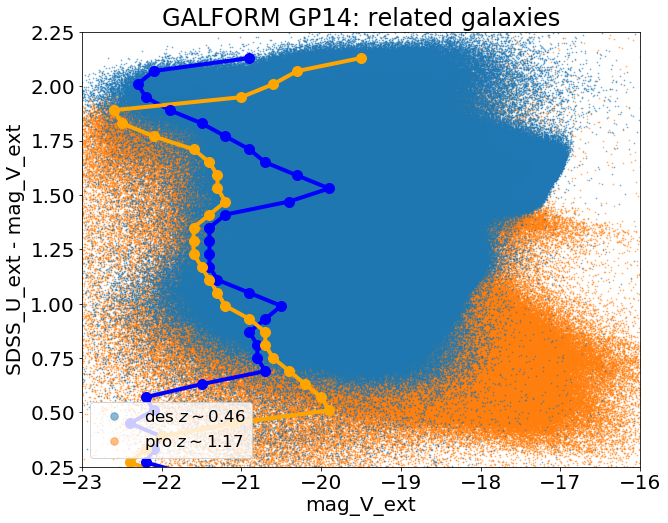

In [143]:
plt.figure(figsize=(10,8))
plt.plot(V_des,UV_des,".",markersize=1.5,color='C0',label=r'des $z\sim0.46$',alpha=0.5,zorder=1)
plt.plot(V_pro,UV_pro,".",markersize=1.5,color='C1',label=r'pro $z\sim1.17$',alpha=0.5,zorder=0)
plt.plot(xedge_des,yedge_des,"-",lw=4,color='blue')
plt.plot(xedge_pro,yedge_pro,"-",lw=4,color='orange')
plt.plot(xedge_des,yedge_des,".",lw=4,color='blue',markersize=20)
plt.plot(xedge_pro,yedge_pro,".",lw=4,color='orange',markersize=20)
plt.legend(markerscale=10,loc='best',fontsize='small')
#for i in range(len(yedge_des)):
#    plt.axhline(yedge_des[i])
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.title('GALFORM GP14: related galaxies')


plt.xlim(-23.,-16.)
plt.ylim(0.25,2.25)

#plt.savefig('../plots/008/bright_edge_GALFORM.png')
plt.show()

In [46]:
VIPERS = Table("../../Data_Sample_V7.fits",hdu=8)

In [47]:
len(VIPERS)

73160

In [48]:
U_vip = VIPERS.getCol("M_Uj")
V_vip = VIPERS.getCol("M_V")
UV_vip =U_vip-V_vip

z_vip = VIPERS.getCol("zspec_1")

z_low_vip= np.where((z_vip>=0.4)&(z_vip<0.5))
z_hig_vip= np.where((z_vip>=1.0)&(z_vip<1.3))

xedge_vip_zlow,yedge_vip_zlow= EDGE(V_vip[z_low_vip],UV_vip[z_low_vip],x_min=-25,x_max=-18,y_min=0.2,y_max=2.4)
xedge_vip_zhigh,yedge_vip_zhigh= EDGE(V_vip[z_hig_vip],UV_vip[z_hig_vip],x_min=-25,x_max=-18,y_min=0.2,y_max=2.4)

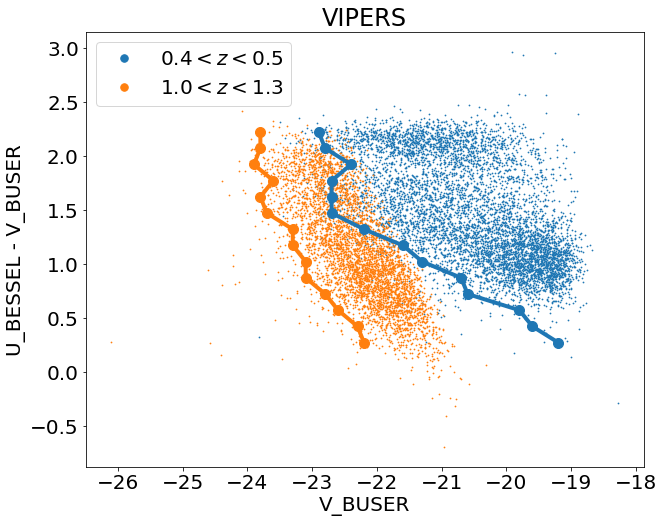

In [49]:
plt.figure(figsize=(10,8))
plt.plot(V_vip[z_low_vip],UV_vip[z_low_vip],".",markersize=1.5,color='C0',label=r'$0.4<z<0.5$')
plt.plot(V_vip[z_hig_vip],UV_vip[z_hig_vip],".",markersize=1.5,color='C1',label=r'$1.0<z<1.3$')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,"-",lw=4,color='C0')
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,"-",lw=4,color='C1')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,".",lw=4,color='C0',markersize=20)
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,".",lw=4,color='C1',markersize=20)
plt.legend(markerscale=10)
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title('VIPERS')
#plt.savefig('../plots/008/bright_edge_VIPERS.png')
plt.show()

In [179]:
4./35.

0.11428571428571428

# Read everything

In [12]:
#pd.read_table('../data/prog37.txt',delimiter=',',comment='#')
Table('../data/prog37.txt')

In [13]:
Out[12].getColNames()

array(['p_galaxyID,', 'p_mag_V_ext,', 'p_SDSS_u_ext,', 'p_stellarmass,',
       'p_mdhalo'], dtype='|S14')

In [14]:
prog37 = Out[12]

In [16]:
len(prog37.getCol('p_mag_V_ext,'))

27618623

In [181]:
des47 = Table('../data/des47.txt')

In [ ]:
plt.figure(figsize=(10,8))
#plt.plot(V_vip[z_low_vip],UV_vip[z_low_vip],".",markersize=1.5,color='C0',label=r'$0.4<z<0.5$')
plt.plot(prog37.getCol('p_mag_V_ext,'),UV_vip[z_hig_vip],".",markersize=1.5,color='C1',label=r'$1.0<z<1.3$')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,"-",lw=4,color='C0')
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,"-",lw=4,color='C1')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,".",lw=4,color='C0',markersize=20)
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,".",lw=4,color='C1',markersize=20)
plt.legend(markerscale=10)
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title('VIPERS')
#plt.savefig('../plots/008/bright_edge_VIPERS.png')
plt.show()

In [183]:
des47.getColNames()

array(['p_galaxyID,', 'p_mag_V_ext,', 'p_SDSS_u_ext,', 'p_stellarmass,',
       'p_mdhalo', ','], dtype='|S14')

Histogram of magnitudes for presentation

In [50]:
colour_bin_fixed = np.where((UV_vip>=1.0)&(UV_vip<1.1))

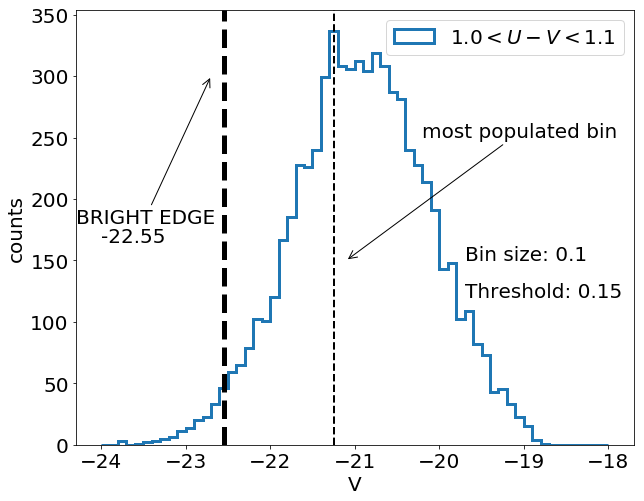

-22.550000381469726


In [177]:
mag_bin_low = -24
mag_bin_high = -18
mag_bin_size=0.1
N_bins= int((mag_bin_high-mag_bin_low)/(mag_bin_size)+0.5)

plt.figure(figsize=(10,8))
plt.hist(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high),label='$1.0 < U - V < 1.1$',histtype='step',lw=3)
counts, x_bins = np.histogram(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high))
histo_max = np.max(counts[:-1])
histo_max_index = np.argmax(counts[:-1])
plt.axvline(x_bins[histo_max_index]+0.05,lw=2,ls='dashed',c='k')

#loop to find the edge
threashold=0.15
for j in range(histo_max_index,0,-1):
    if (counts[j]<histo_max * threashold):
        edge_index = j
        break
        
plt.axvline(x_bins[j]+0.05,lw=5,ls='dashed',c='k')
    
plt.xlabel(r'V')
plt.ylabel('counts')

#plt.arrow(-23.7,200,0.8,30)#,head_length=6,head_width=0.5, fc='k', ec='k',overhang=0,capstyle='projecting')
#plt.text(-24.3,180,"BRIGHT EDGE")

plt.annotate("BRIGHT EDGE", xy=(-22.7,300), xytext=(-24.3,180), arrowprops=dict(arrowstyle="->"))
plt.text(-24.,165,round(x_bins[j]+mag_bin_size/2.,2))

plt.annotate("most populated bin", xy=(-21.1,150), xytext=(-20.2,250), arrowprops=dict(arrowstyle="->"))
plt.legend()

plt.text(-19.7,150.,"Bin size: "+str(mag_bin_size))
plt.text(-19.7,120.,"Threshold: "+str(threashold))


plt.savefig('../../presentations/FLAT/defining_edge_histo_1.png')
plt.show()
print x_bins[j]+0.05

-22.650000762939452


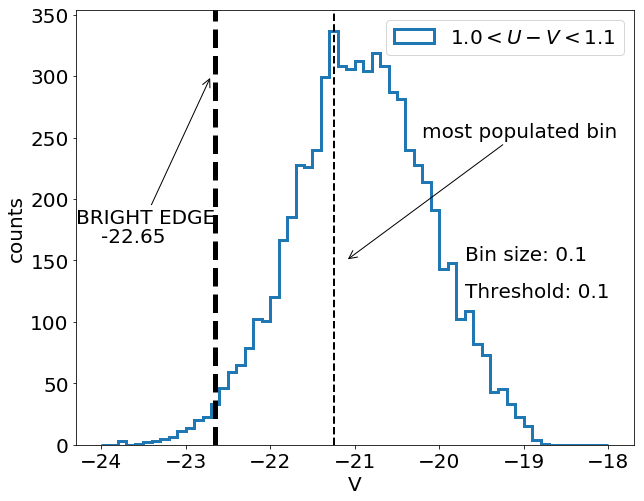

In [178]:
mag_bin_low = -24
mag_bin_high = -18
mag_bin_size=0.1
threashold=0.10
#---------------------------------------
N_bins= int((mag_bin_high-mag_bin_low)/(mag_bin_size)+0.5)

plt.figure(figsize=(10,8))
plt.hist(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high),label='$1.0 < U - V < 1.1$',histtype='step',lw=3)
counts, x_bins = np.histogram(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high))
histo_max = np.max(counts[:-1])
histo_max_index = np.argmax(counts[:-1])
plt.axvline(x_bins[histo_max_index]+0.05,lw=2,ls='dashed',c='k')

#loop to find the edge

for j in range(histo_max_index,0,-1):
    if (counts[j]<histo_max * threashold):
        edge_index = j
        break
        
plt.axvline(x_bins[j]+mag_bin_size/2.,lw=5,ls='dashed',c='k')
    
plt.xlabel(r'V')
plt.ylabel('counts')

#plt.arrow(-23.7,200,0.8,30)#,head_length=6,head_width=0.5, fc='k', ec='k',overhang=0,capstyle='projecting')
#plt.text(-24.3,180,"BRIGHT EDGE")

plt.annotate("BRIGHT EDGE", xy=(-22.7,300), xytext=(-24.3,180), arrowprops=dict(arrowstyle="->"))
plt.text(-24.,165,round(x_bins[j]+mag_bin_size/2.,2))

plt.annotate("most populated bin", xy=(-21.1,150), xytext=(-20.2,250), arrowprops=dict(arrowstyle="->"))
plt.legend()


plt.text(-19.7,150.,"Bin size: "+str(mag_bin_size))
plt.text(-19.7,120.,"Threshold: "+str(threashold))


plt.savefig('../../presentations/FLAT/defining_edge_histo_2.png')
#plt.show()

print x_bins[j]+0.05

-22.749999237060546


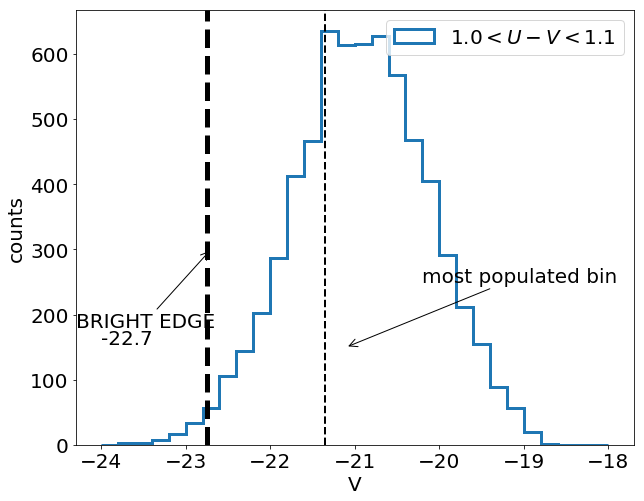

In [179]:
mag_bin_low = -24
mag_bin_high = -18
mag_bin_size=0.2
threashold=0.10
#---------------------------------------
N_bins= int((mag_bin_high-mag_bin_low)/(mag_bin_size)+0.5)

plt.figure(figsize=(10,8))
plt.hist(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high),label='$1.0 < U - V < 1.1$',histtype='step',lw=3)
counts, x_bins = np.histogram(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high))
histo_max = np.max(counts[:-1])
histo_max_index = np.argmax(counts[:-1])
plt.axvline(x_bins[histo_max_index]+0.05,lw=2,ls='dashed',c='k')

#loop to find the edge

for j in range(histo_max_index,0,-1):
    if (counts[j]<histo_max * threashold):
        edge_index = j
        break
        
plt.axvline(x_bins[j]+0.05,lw=5,ls='dashed',c='k')
    
plt.xlabel(r'V')
plt.ylabel('counts')

#plt.arrow(-23.7,200,0.8,30)#,head_length=6,head_width=0.5, fc='k', ec='k',overhang=0,capstyle='projecting')
#plt.text(-24.3,180,"BRIGHT EDGE")

plt.annotate("BRIGHT EDGE", xy=(-22.7,300), xytext=(-24.3,180), arrowprops=dict(arrowstyle="->"))
plt.text(-24.,155,round(x_bins[j]+mag_bin_size/2.,2))


plt.annotate("most populated bin", xy=(-21.1,150), xytext=(-20.2,250), arrowprops=dict(arrowstyle="->"))
plt.legend()

plt.savefig('../../presentations/FLAT/defining_edge_histo_3.png')
#plt.show()

print x_bins[j]+0.05

-22.64999923706055


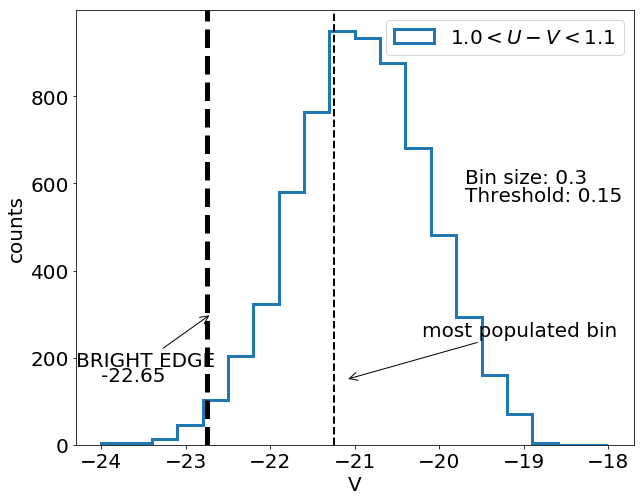

In [180]:
mag_bin_low = -24
mag_bin_high = -18
mag_bin_size=0.3
threashold=0.15
#---------------------------------------
N_bins= int((mag_bin_high-mag_bin_low)/(mag_bin_size)+0.5)

plt.figure(figsize=(10,8))
plt.hist(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high),label='$1.0 < U - V < 1.1$',histtype='step',lw=3)
counts, x_bins = np.histogram(V_vip[colour_bin_fixed],bins=N_bins,range=(mag_bin_low,mag_bin_high))
histo_max = np.max(counts[:-1])
histo_max_index = np.argmax(counts[:-1])
plt.axvline(x_bins[histo_max_index]+0.05,lw=2,ls='dashed',c='k')

#loop to find the edge

for j in range(histo_max_index,0,-1):
    if (counts[j]<histo_max * threashold):
        edge_index = j
        break
        
plt.axvline(x_bins[j]+0.05,lw=5,ls='dashed',c='k')
    
plt.xlabel(r'V')
plt.ylabel('counts')

#plt.arrow(-23.7,200,0.8,30)#,head_length=6,head_width=0.5, fc='k', ec='k',overhang=0,capstyle='projecting')
#plt.text(-24.3,180,"BRIGHT EDGE")

plt.annotate("BRIGHT EDGE", xy=(-22.7,300), xytext=(-24.3,180), arrowprops=dict(arrowstyle="->"))
plt.text(-24.,145,round(x_bins[j]+mag_bin_size/2.,2))


plt.text(-19.7,600.,"Bin size: "+str(mag_bin_size))
plt.text(-19.7,560.,"Threshold: "+str(threashold))

plt.annotate("most populated bin", xy=(-21.1,150), xytext=(-20.2,250), arrowprops=dict(arrowstyle="->"))
plt.legend()

plt.savefig('../../presentations/FLAT/defining_edge_histo_4.png')
#plt.show()

print x_bins[j]+mag_bin_size/2.